## Importing the goodies and defining some paths

In [19]:
!pip install Augmentor
import numpy as np
import os, os.path
from PIL import Image
from numpy import moveaxis
import matplotlib
import matplotlib.pyplot as plt 
import scipy
from scipy import ndimage
import Augmentor
import os

categories = [ "LYMPHOCYTE", 
              "EOSINOPHIL",
              "NEUTROPHIL",
              "MONOCYTE" ]


ROOT = "/content/drive/My Drive/kaggle/blood_cells/"
sample_image_path_2 = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/"
sample_image_path_aug = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/output/"
sample_image_path = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_651.jpeg"
sandbox_path = ROOT + "sandbox"
sandbox_op = ROOT + "sandbox/output/"

LYMPHOCYTE_folder_path = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/"
EOSINOPHIL_folder_path = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/"
NEUTROPHIL_folder_path = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/"
MONOCYTE_folder_path = ROOT + "blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/"

## Some basic utilities 
* `img_to_arr()` takes in the path of an image and returns a numpy array of the image, moveaxis() is optional depending on whether we want to feed it to a CNN or to simply just show it.
* Keep moveaxis = False when you want to plot and view it, or moveaxis  = True when it needs to be used for training data 
* `show_samples_from_folder()` iterates through all the images in a folder and plots them.

In [0]:
def img_to_arr(im_path, move_axis = True):
    img = Image.open(im_path)
    x = np.array(img)
    if move_axis == True:
        x = moveaxis(x, 2, 0)
    return x


def show_samples_from_folder(folder_path):
    images = []
    for i in os.listdir(folder_path):
        im_path = folder_path + "/" + i
        img = img_to_arr(im_path, move_axis = False)
        images.append(img)
    
    f = plt.figure(figsize = (40,20))

    for m in range (1,len(images)+1):
        f.add_subplot(1,len(images), m)
        plt.imshow(images[m-1])             
       
    plt.show()

## Experimenting on a single image first to test out some augmentation techniques

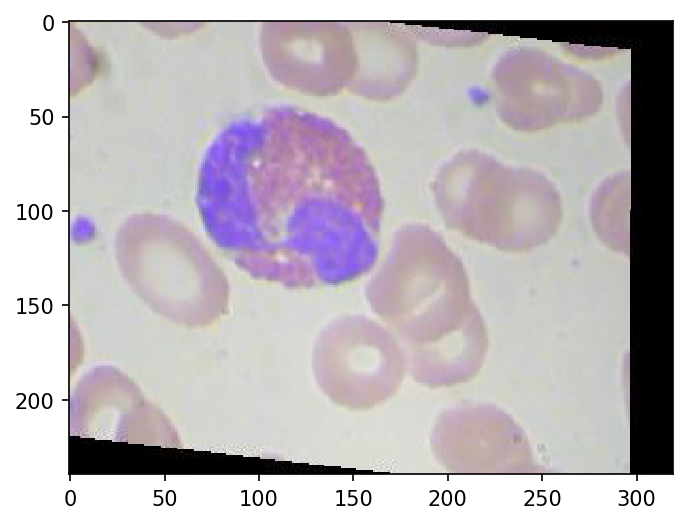

In [6]:
matplotlib.rcParams['figure.dpi'] = 150

im_arr = img_to_arr(ROOT +"sandbox/_0_6354.jpeg")
np_im = np.moveaxis(im_arr, 0,2)
plt.imshow(np_im)
plt.show()

## Defining an augmentation pipeline 
* `Augmentor.Pipeline(folder_path)` is used to initiate the process and select the folder whose images we have to augment 
* `p.random_distortion()` distorts the image upto a certain extent depending upon the argument "magnitude". 
* `probability = 1` means that the augmentation would happen on all the images it iterates through
* `p.flip_left_right(probability=0.5)` makes a sideways mirror image of the image it iterates through with a probability of 50%
* `p.crop_random(probability=1, percentage_area=0.9)` generates a random crop.
> * percentage_area is 0.9 and not any lower because upon visual inspection of the dataset, some of the images had the violet part ( which I suppose might be important ) near the edges of the image. 
> * And it might just be so that the violet part itself gets cut out if I crop too much
* And to bring back the cropped images to their original size, `p.resize()` was used 

In [12]:
p = Augmentor.Pipeline(sandbox_path)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)
p.crop_random(probability=1, percentage_area=0.9)
p.resize(probability=1.0, width=320, height=240)

Initialised with 1 image(s) found.
Output directory set to /content/drive/My Drive/kaggle/blood_cells/sandbox/output.

## Generating 5 samples 
* Images get saved in a new folder within the folder where the original images were

In [13]:
p.sample(5)

Processing <PIL.Image.Image image mode=RGB size=320x240 at 0x7FF57C5DFC50>: 100%|██████████| 5/5 [00:00<00:00, 60.64 Samples/s]


## Viewing a few samples because why not

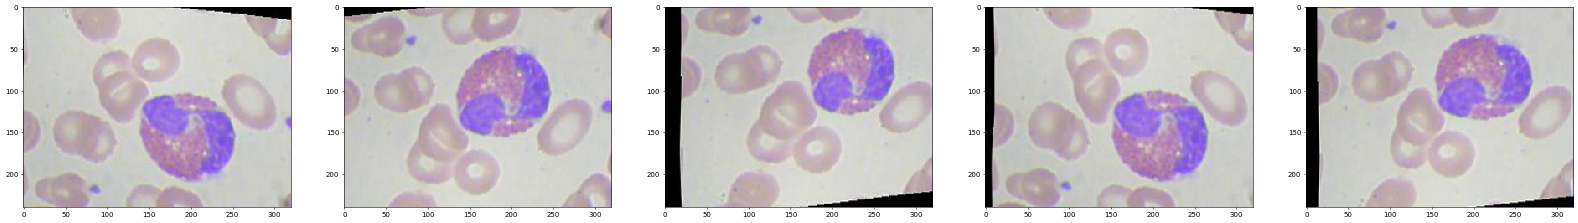

In [15]:
matplotlib.rcParams['figure.dpi'] = 50

show_samples_from_folder(sandbox_op)

## Generating training data from the original image dataset
* `generate_train_data()` goes through all the images in a folder and stacks them as numpy arrays with the respective label as passed in the argument.

In [0]:
def generate_train_data(source_folder, save_path, filename,  onehot_label = [0,0,0,0]):
    save_path = save_path + filename
    final_stack = []
    for i in os.listdir(source_folder):   # i is the img_name btw
       
        im_path = source_folder + "/" + i
        label = np.array(onehot_label)
        im_arr = img_to_arr(im_path)
        stack_element = [im_arr, label]
        stack_element = np.array(stack_element)
        # print(stack_element)
        final_stack.append(stack_element)
    final_stack = np.array(final_stack)
    print (final_stack.shape[0], " instances in ", filename)
    fmt_name = save_path
    np.save(fmt_name, final_stack)
    print ("saved -- ", fmt_name)


In [69]:
generate_train_data(source_folder = LYMPHOCYTE_folder_path, save_path = sandbox_op , filename  = "LYMPHOCYTE.npy",  onehot_label = [1,0,0,0])

2483  instances 
saved --  /content/drive/My Drive/kaggle/blood_cells/sandbox/output/LYMPHOCYTE.npy


In [21]:
generate_train_data(source_folder = EOSINOPHIL_folder_path, save_path = sandbox_op , filename  = "EOSINOPHIL.npy",  onehot_label = [0,1,0,0])
generate_train_data(source_folder = NEUTROPHIL_folder_path, save_path = sandbox_op , filename  = "NEUTROPHIL.npy",  onehot_label = [0,0,1,0])
generate_train_data(source_folder = MONOCYTE_folder_path, save_path = sandbox_op , filename  = "MONOCYTE.npy",  onehot_label = [0,0,0,1])

2497  instances 
saved --  /content/drive/My Drive/kaggle/blood_cells/sandbox/output/EOSINOPHIL.npy
2499  instances 
saved --  /content/drive/My Drive/kaggle/blood_cells/sandbox/output/NEUTROPHIL.npy
2478  instances 
saved --  /content/drive/My Drive/kaggle/blood_cells/sandbox/output/MONOCYTE.npy
